In [51]:
import numpy as np
from matplotlib import pyplot as plt
import ctypes
import math
from scipy.integrate import solve_ivp
#Load aux shared library
clib = ctypes.CDLL('./lib/auxlib.so')

#Define the shared library functions signature
clib.henon_attractor.argtypes = [ctypes.c_float, ctypes.c_float, ctypes.c_float, ctypes.c_float,
                                 ctypes.c_float, ctypes.c_float, ctypes.c_float, ctypes.c_float,
                                 ctypes.c_int]
clib.henon_attractor.restype = ctypes.POINTER(ctypes.c_float)

<p> O artigo "Chaos, Strange Attractors, and Fractal Basin Boundaries in Nonlinear Dynamics", de Grebogi, Ott e Yorke, apresenta diversos conceitos e resultados importantes para o estudo de sistemas dinâmicos caóticos. Esse trabalho apresentará os principais pontos desse artigo e replicará os gráficos que foram utilizados para exemplificar conceitos e resultados.
</p>

<p> Primeiramente, o <en>paper</en> apresenta alguns conceitos iniciais, tais como o atrator, o atrator estranho, ou seja, atratores com formas fractais, e dimensão, definida no artigo como sendo a dimensão de <en>counting boxes</en>. A seguir, mostra-se o atrator caótico do mapa de Henón (para a = 1.4 e b = 0.3)
</p>

In [8]:
def henon_attractor(a, b, ndisc, niter):
    henon_map = lambda x, y: (a-x**2+b*y, x)
    x = y = 0.0

    for _ in range(ndisc):
        x, y = henon_map(x, y)

    X = []
    Y = []
    # A função clib.henon_attractor faz o cálculo de 10000 em 10000 para evitar Stack Overflow
    for i in range(math.ceil(niter/10000.0)):
        c_niter = min(10000, niter-i*10000)
        result = clib.henon_attractor(a, b, x, y, c_niter)
        orbit = ctypes.cast(result, ctypes.POINTER(ctypes.c_float * (2 * c_niter)))
        X += orbit[0][:c_niter]
        Y += orbit[0][c_niter:]
        x = X[-1]
        y = Y[-1]
    
    return np.array(X), np.array(Y)

Xa, Ya = henon_attractor(1.4, 0.3, -2, 2, -2, 2, 100, 100000)

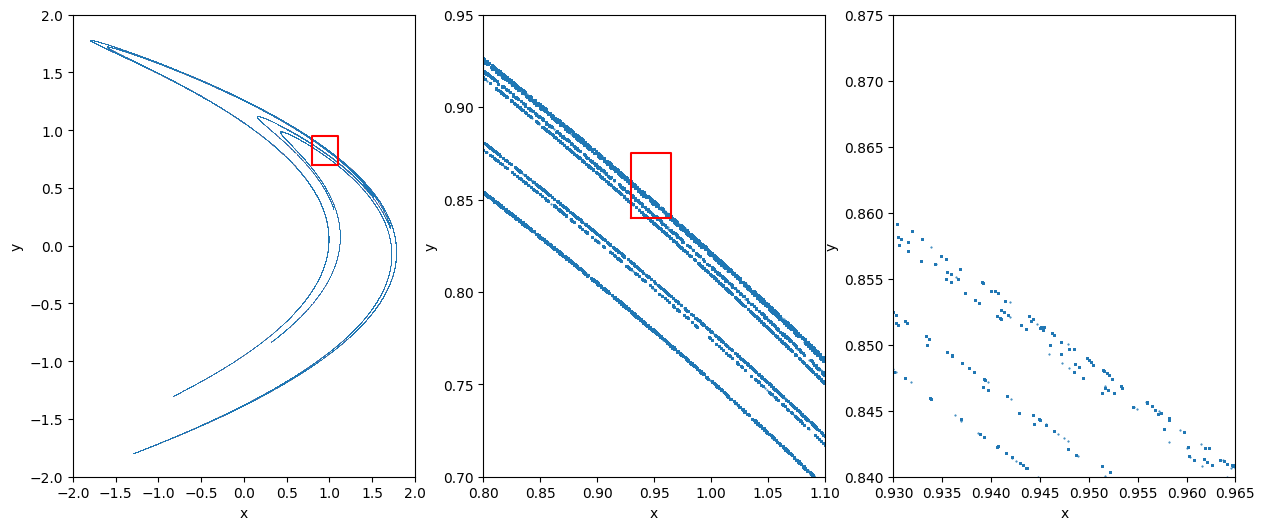

In [50]:
_, axs = plt.subplots(1,3, figsize = (15, 6), squeeze=False)

ax = axs[0][0]
ax.scatter(X, Y, marker = '.', s = 1, alpha = 0.005)
ax.plot([0.8, 0.8, 1.1, 1.1, 0.8], [0.7, 0.95, 0.95, 0.7, 0.7], color = 'r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

ax = axs[0][1]
ax.scatter(X, Y, marker = '.', s = 1)
ax.plot([0.93, 0.93, 0.965, 0.965, 0.93], [0.84, 0.875, 0.875, 0.84, 0.84], color = 'r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(0.8,1.1)
ax.set_ylim(0.7,0.95)

ax = axs[0][2]
ax.scatter(X, Y, marker = '.', s = 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(0.93,0.965)
ax.set_ylim(0.84,0.875)
plt.show()

Percebe-se que o atrator tem formato fractal, de modo que independentemente do zoom dado na imagem os padrões de linhas estarão presentes. Os atratores caóticos também são vistos para o pêndulo amortecido forçado periodicamente, cujo movimento é determinado pela EDO:

$$
\frac{d^2\theta}{dt^2} + \frac{0.22d\theta}{dt} + \sin{\theta} = 2.7\cos{t}
$$

Se considerarmos o mapa obtido ao considerar os tempos $t = 2k\pi$ temos a figura a seguir.

In [37]:
def pendulum_ODE(t, y, v, f):

    theta, theta_ = y
    dtheta_dt = theta_
    dtheta_dt_2 = -v*theta_ - np.sin(theta) + f*np.cos(t)

    return[dtheta_dt, dtheta_dt_2]

t_points = np.arange(0, 100000, 2*np.pi)
initial_conditions = [0, 0]
t_span = (0, t_points[-1])


v = 0.22
f = 2.7

solution = solve_ivp(pendulum_ODE, t_span, initial_conditions, t_eval=t_points, args=(v,f), method='DOP853', max_step = 0.1)

theta_values = np.array(solution.y[0])
theta_values = np.mod(theta_values, 2*np.pi)
theta_values = np.where(theta_values > np.pi, theta_values-2*np.pi, theta_values)

dtheta_values = solution.y[1]

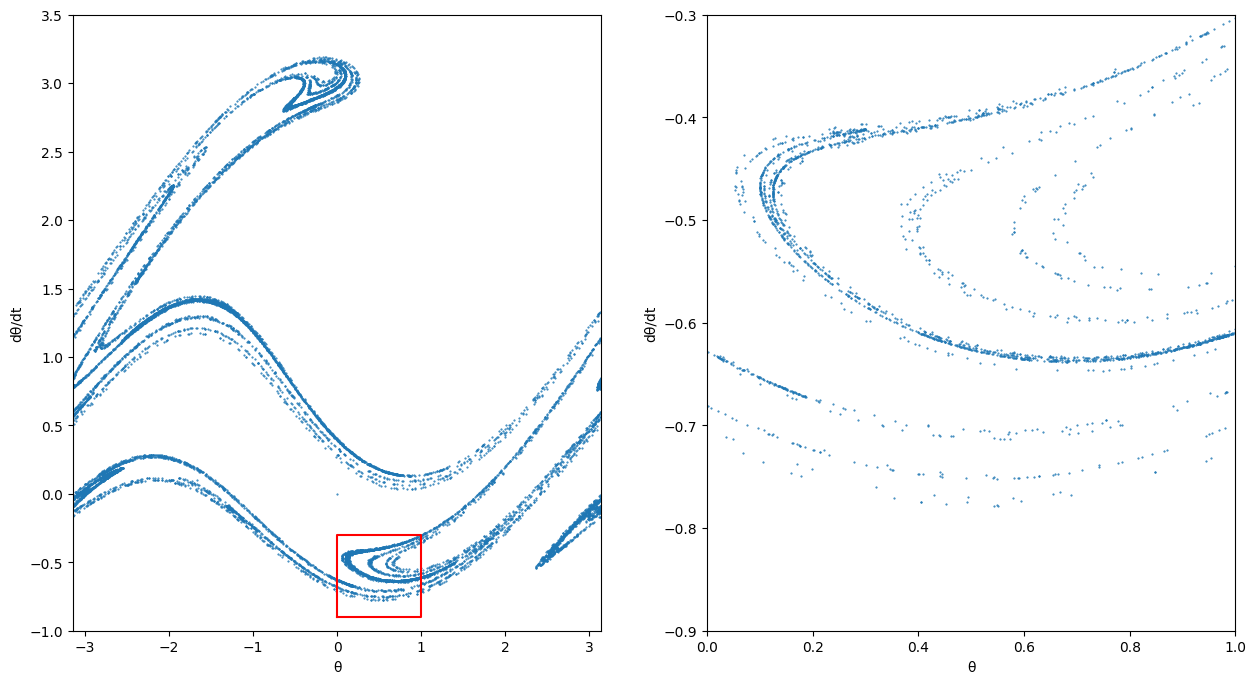

In [41]:
fig, axs = plt.subplots(1,2, squeeze=False, figsize = (15,8))

ax = axs[0][0]
ax.scatter(theta_values, dtheta_values, s = 1, marker = ".")
ax.plot([0,0,1,1,0], [-0.9, -0.3, -0.3, -0.9, -0.9], color = 'r')
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-1,3.5)
ax.set_xlabel('θ')
ax.set_ylabel('dθ/dt')

ax = axs[0][1]
ax.scatter(theta_values, dtheta_values, s = 1, marker = ".")
ax.set_xlim(0,1)
ax.set_ylim(-0.9,-0.3)
ax.set_xlabel('θ')
ax.set_ylabel('dθ/dt')

plt.show()